<a href="https://colab.research.google.com/github/sushily1997/Crop_Prediction_System-/blob/main/Crop_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score as acc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import r2_score
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

#**Data** **Loading**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/crop.csv')
print('Data Shape: ', df.shape)

Data Shape:  (2200, 8)


In [ ]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


# **Data fields**

N - ratio of Nitrogen content in soil

P - ratio of Phosphorous content in soil

K - ratio of Potassium content in soil

temperature - temperature in degree Celsius

humidity - relative humidity in %

ph - ph value of the soil

rainfall - rainfall in mm

#**EDA**

In [ ]:
## info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


**Observation:** Clearly there are no missing values. And also, the data is equally distributed.

In [ ]:
# type of data

df.dtypes

N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

In [ ]:
df.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [ ]:
# Unique Name of the Crops in Dataset
crops = df['label'].unique()
crops.sort()
print ("Total Number of Crops Data: ", len(crops) )
print("\n","-"*20, " List of Crops ", "-"*20)
crops.tolist()

Total Number of Crops Data:  22

 --------------------  List of Crops  --------------------


['apple',
 'banana',
 'blackgram',
 'chickpea',
 'coconut',
 'coffee',
 'cotton',
 'grapes',
 'jute',
 'kidneybeans',
 'lentil',
 'maize',
 'mango',
 'mothbeans',
 'mungbean',
 'muskmelon',
 'orange',
 'papaya',
 'pigeonpeas',
 'pomegranate',
 'rice',
 'watermelon']

In [ ]:
df.label.unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [ ]:
# get top 5 most frequent growing crops
n = 5
df['label'].value_counts()[:5].index.tolist()

['rice', 'maize', 'jute', 'cotton', 'coconut']

In [ ]:
# Number of Rows against each Crop
print("Number of Records Against Eash Crop")
print("-"*35)
print(df['label'].value_counts() )

Number of Records Against Eash Crop
-----------------------------------
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64


In [ ]:
#Columns Name
df.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

In [ ]:
# Features Selection
selected_features = {'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'}
selected_features

{'K', 'N', 'P', 'humidity', 'ph', 'rainfall', 'temperature'}

In [ ]:
## descripe

df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


**Observation:** Since Mean and Median are almost similar, no scaling is required.

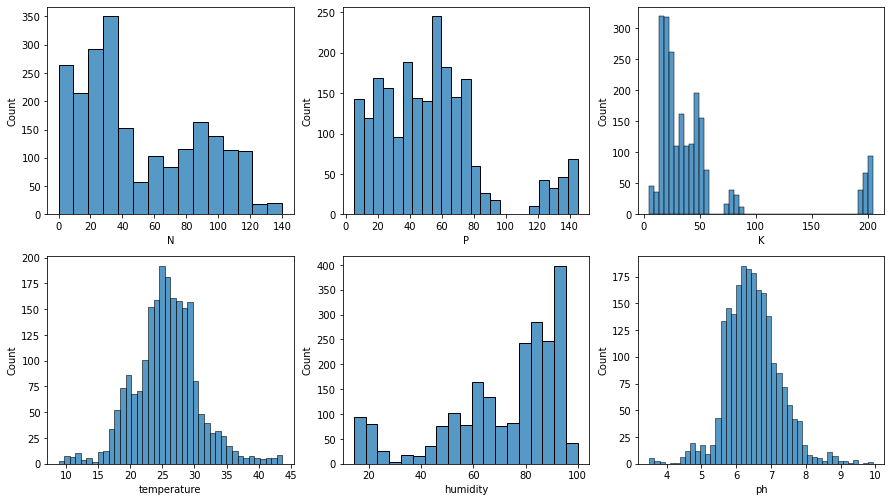

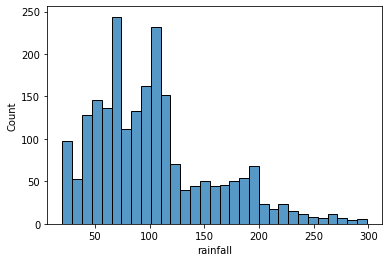

In [ ]:
all_columns = df.columns[:-1]

plt.figure(figsize=(15,13))
i = 1
for column in all_columns[:-1]:
    plt.subplot(3,3,i)
    sns.histplot(df[column])
    i+=1
plt.show()

sns.histplot(df[all_columns[-1]])
plt.show()

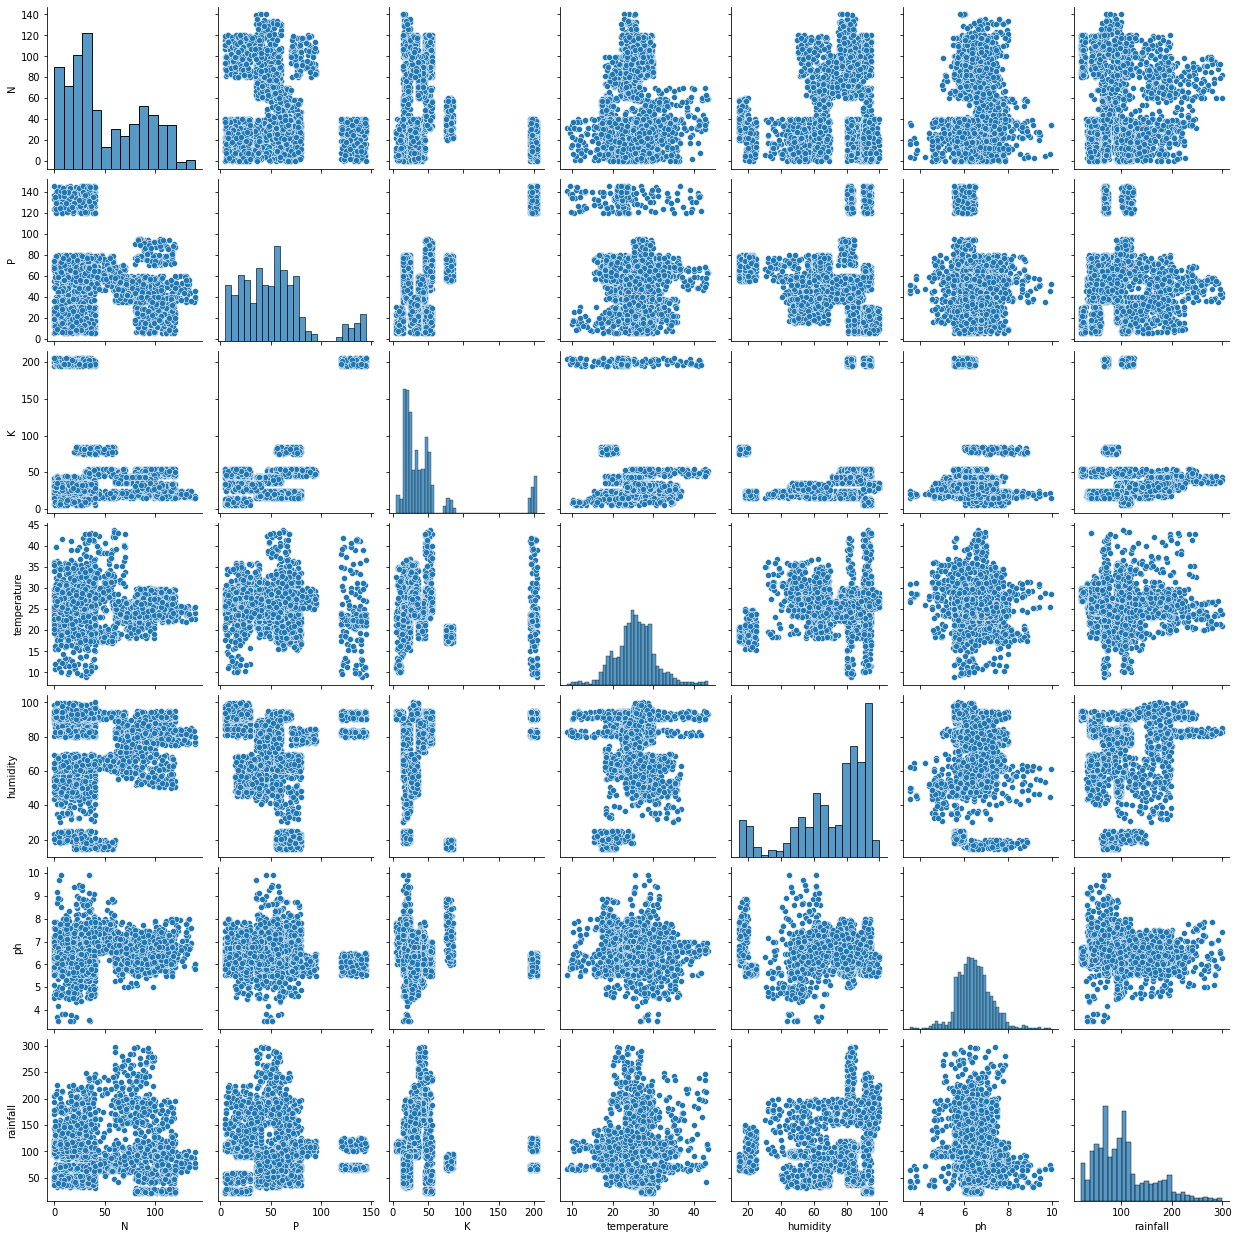

In [ ]:
p = sns.pairplot(df)

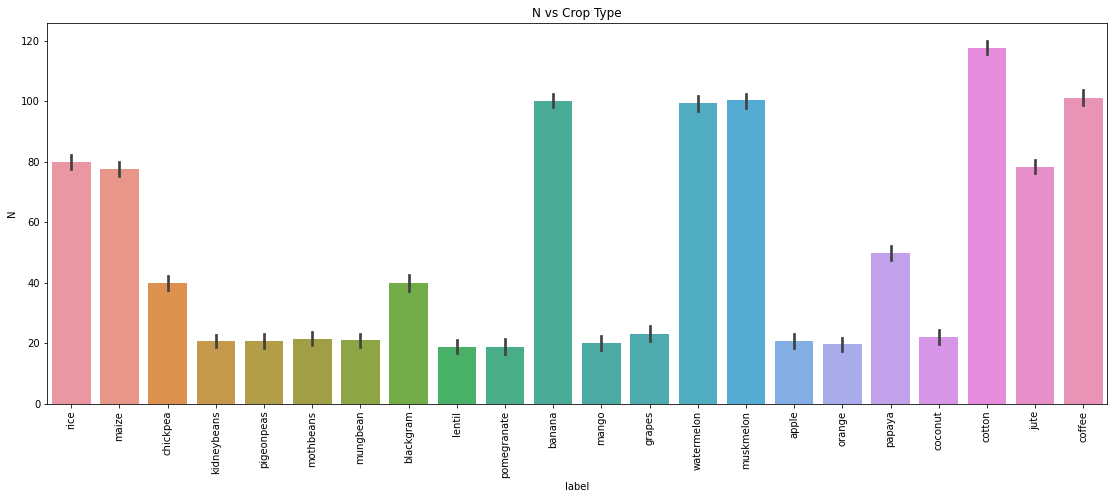

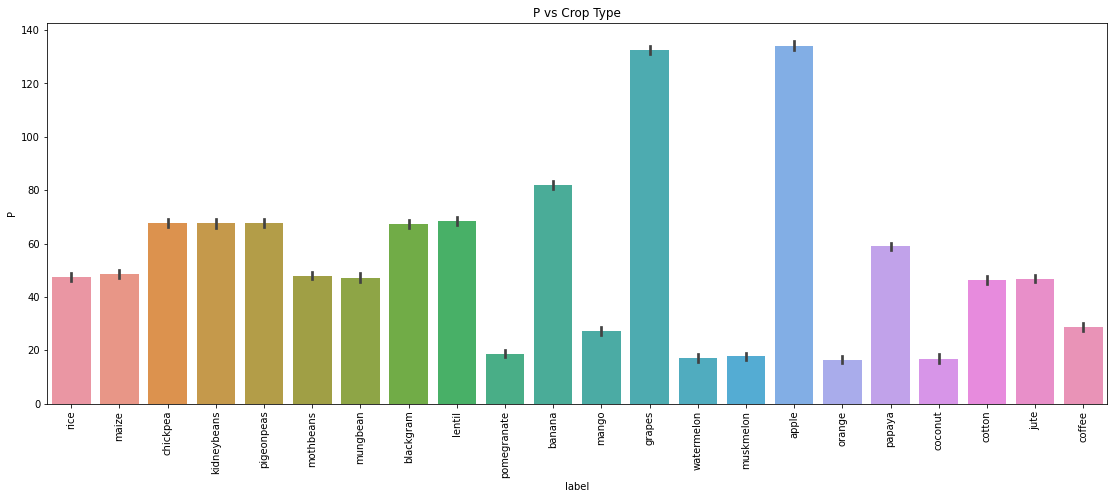

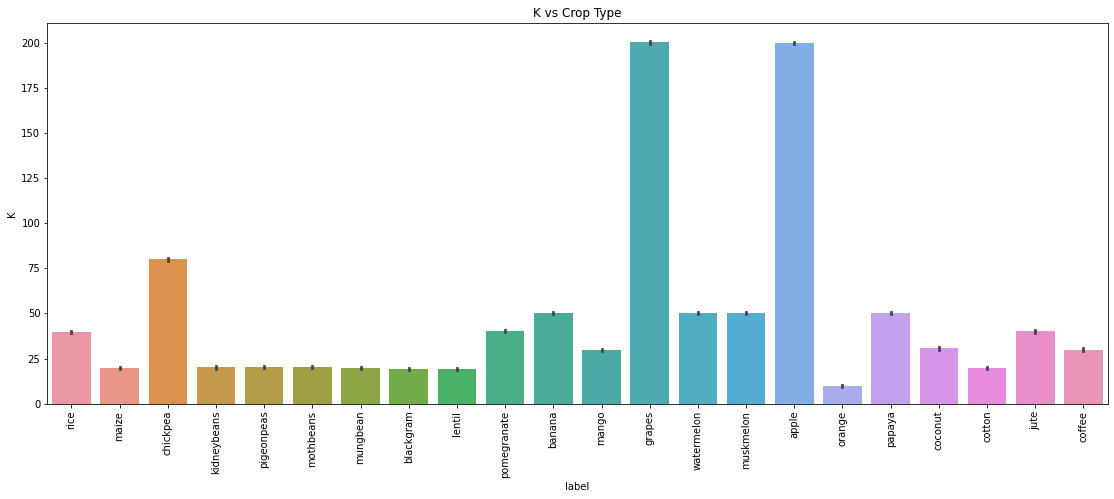

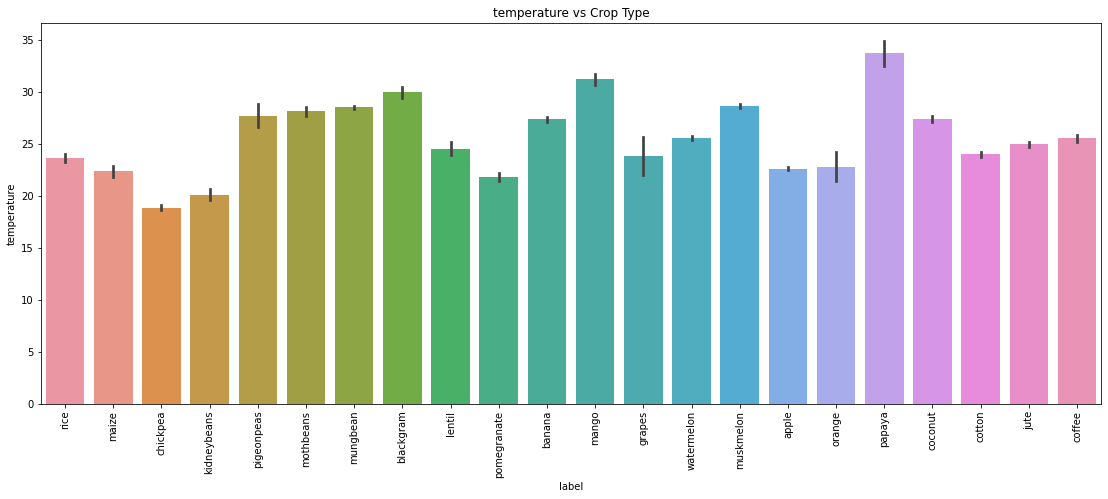

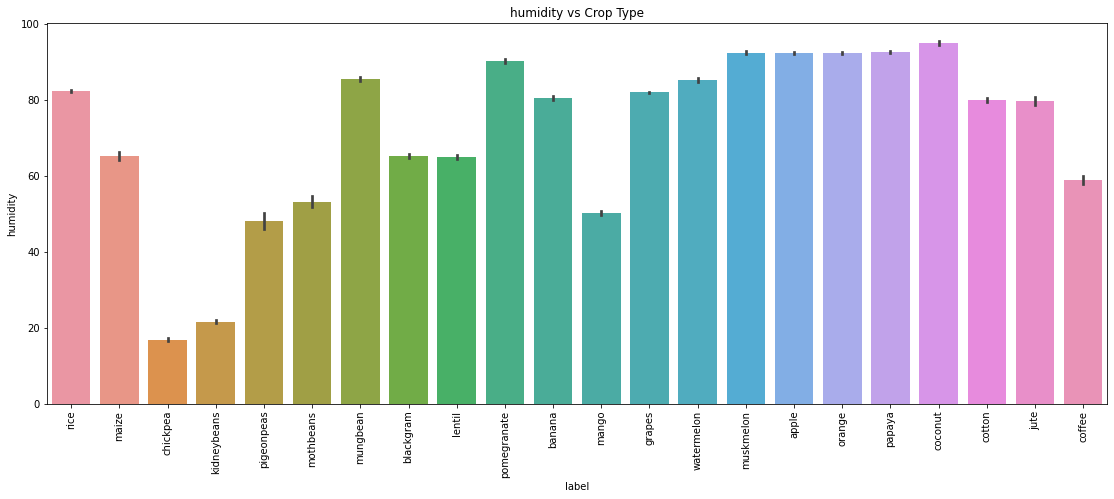

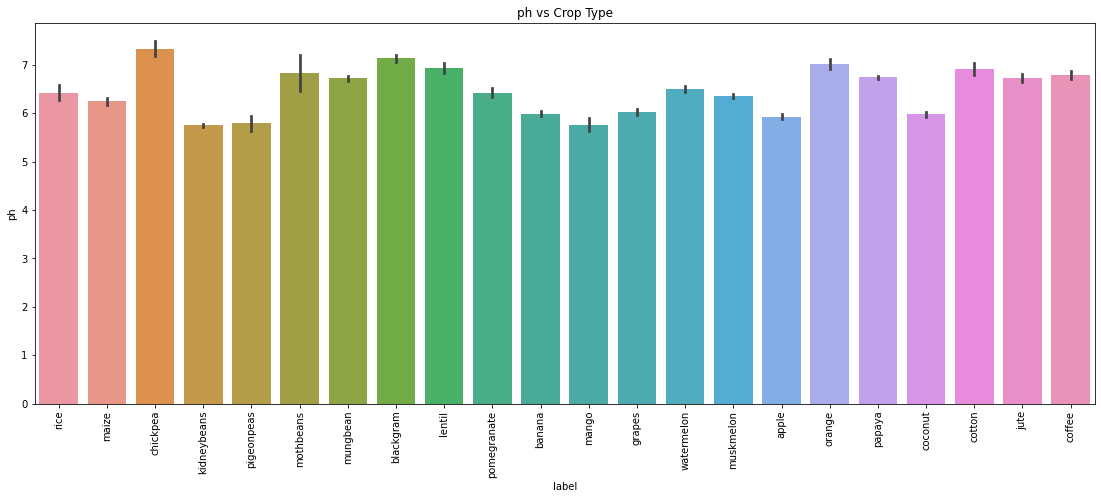

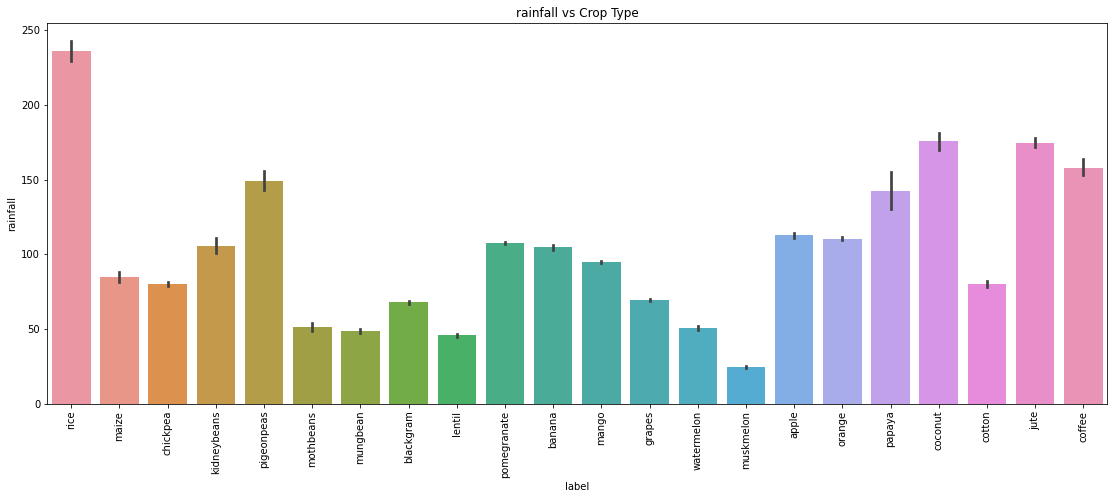

In [ ]:
for column in all_columns:
    plt.figure(figsize=(19,7))
    sns.barplot(x = "label", y = column, data = df)
    plt.xticks(rotation=90)
    plt.title(f"{column} vs Crop Type")
    plt.show()

In [ ]:
df.corr()

,N,P,K,temperature,humidity,ph,rainfall
N,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
P,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
K,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
ph,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


Text(0.5, 1.0, 'Correlation Matrix')

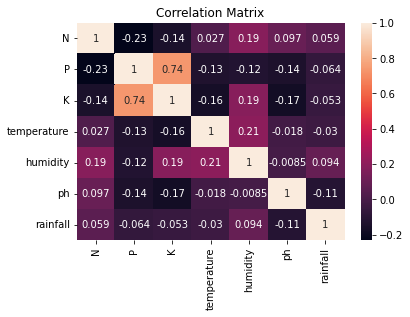

In [ ]:
sns.heatmap(df.corr(), annot =True)
plt.title('Correlation Matrix')

In [ ]:
# Shuffling data to remove order effects

# shuffling the dataset to remove order

df  = shuffle(df,random_state=5)
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
1270,6,140,205,17.665584,82.929034,6.313086,69.867126,grapes
1481,98,22,47,29.072653,91.915332,6.341401,28.835684,muskmelon
1832,38,14,30,26.924495,91.201060,5.570745,194.902214,coconut
293,35,63,76,17.815645,17.607566,7.714153,90.820976,chickpea
1307,85,22,53,25.965342,89.770767,6.849472,59.463386,watermelon


#**Assumptions for Linear Regression**

##**1. Linearity**

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


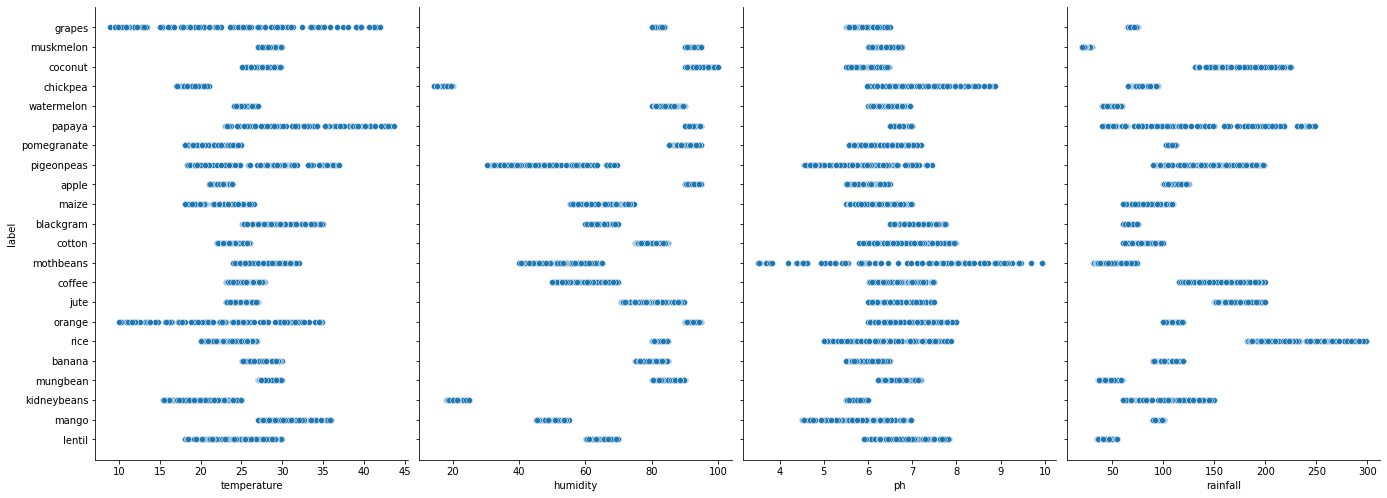

In [ ]:
	p = sns.pairplot(df, x_vars=['temperature',	'humidity',	'ph',	'rainfall'], y_vars='label', size=7, aspect=0.7)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


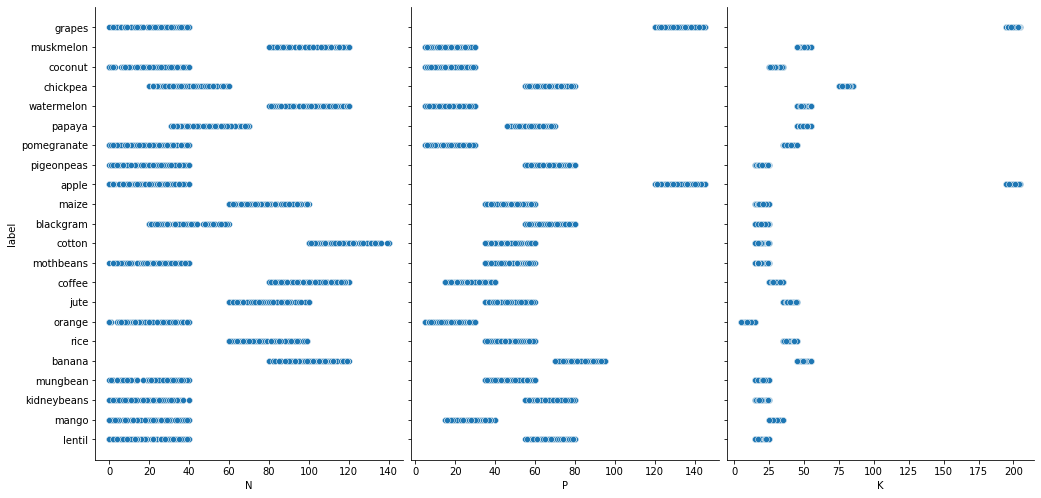

In [ ]:
# visualize the relationship between the features and the response using scatterplots
p = sns.pairplot(df, x_vars=['N',	'P',	'K'], y_vars='label', size=7, aspect=0.7)

#**Encoding target variable** 

In [ ]:
xdf = df.copy()
xdf

,N,P,K,temperature,humidity,ph,rainfall,label
1270,6,140,205,17.665584,82.929034,6.313086,69.867126,grapes
1481,98,22,47,29.072653,91.915332,6.341401,28.835684,muskmelon
1832,38,14,30,26.924495,91.201060,5.570745,194.902214,coconut
293,35,63,76,17.815645,17.607566,7.714153,90.820976,chickpea
1307,85,22,53,25.965342,89.770767,6.849472,59.463386,watermelon
...,...,...,...,...,...,...,...,...
740,24,80,19,29.678925,69.085455,6.808042,65.664366,blackgram
1032,105,74,45,25.145176,81.382041,6.098369,119.218154,banana
2121,83,21,28,25.567483,60.492446,7.466901,190.225784,coffee
1424,102,25,50,28.204808,92.914404,6.099662,20.360011,muskmelon


In [ ]:
labelencoder= LabelEncoder() # initializing an object of class LabelEncoder

#Fit and Transforming the label column.
xdf['label_codes'] = labelencoder.fit_transform(xdf['label']) 
xdf

,N,P,K,temperature,humidity,ph,rainfall,label,label_codes
1270,6,140,205,17.665584,82.929034,6.313086,69.867126,grapes,7
1481,98,22,47,29.072653,91.915332,6.341401,28.835684,muskmelon,15
1832,38,14,30,26.924495,91.201060,5.570745,194.902214,coconut,4
293,35,63,76,17.815645,17.607566,7.714153,90.820976,chickpea,3
1307,85,22,53,25.965342,89.770767,6.849472,59.463386,watermelon,21
...,...,...,...,...,...,...,...,...,...
740,24,80,19,29.678925,69.085455,6.808042,65.664366,blackgram,2
1032,105,74,45,25.145176,81.382041,6.098369,119.218154,banana,1
2121,83,21,28,25.567483,60.492446,7.466901,190.225784,coffee,5
1424,102,25,50,28.204808,92.914404,6.099662,20.360011,muskmelon,15


In [ ]:
y = xdf['label_codes'] # Targeted Values Selection
X = xdf[selected_features] # Independent Values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
X

,ph,P,K,N,temperature,rainfall,humidity
1270,6.313086,140,205,6,17.665584,69.867126,82.929034
1481,6.341401,22,47,98,29.072653,28.835684,91.915332
1832,5.570745,14,30,38,26.924495,194.902214,91.201060
293,7.714153,63,76,35,17.815645,90.820976,17.607566
1307,6.849472,22,53,85,25.965342,59.463386,89.770767
...,...,...,...,...,...,...,...
740,6.808042,80,19,24,29.678925,65.664366,69.085455
1032,6.098369,74,45,105,25.145176,119.218154,81.382041
2121,7.466901,21,28,83,25.567483,190.225784,60.492446
1424,6.099662,25,50,102,28.204808,20.360011,92.914404


In [ ]:
y

1270     7
1481    15
1832     4
293      3
1307    21
        ..
740      2
1032     1
2121     5
1424    15
1725    17
Name: label_codes, Length: 2200, dtype: int64

**Splitting the data into training data and testing data**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)
print(X.shape,X_train.shape,X_test.shape)

(2200, 7) (1540, 7) (660, 7)


**Model build- linear .fit .predict**

In [ ]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()  ## importing the model object
LR.fit(X_train,y_train) ## fitting the training data

X_test_pred=LR.predict(X_test)

In [ ]:
X_test_pred

array([13.17094133, 12.60485535, 12.61020652, 16.22374174, 12.70432944,
        9.5585446 ,  3.9243196 ,  9.44326504,  7.19009651,  9.21647404,
       10.9447572 , 11.91527911, 13.1222031 , 13.54400332, 13.38928996,
        9.76508799,  7.102084  ,  4.90422884, 11.17396388,  8.55836891,
       10.82194687, 12.52707365,  7.04328855,  9.80249154,  8.11963205,
       16.41047684,  9.88752955, 12.61113216, 14.82808741,  9.46017551,
        8.97353645, 14.38706549, 13.52075914, 14.75046909, 12.2435956 ,
       16.07839024,  7.49818623, 11.20529593, 16.78775299, 10.21237914,
       15.45632659,  9.11822639, 10.09970587, 11.45332247, 11.08082137,
        5.41622442,  9.79923404,  2.45304359, 14.72722826, 13.93166994,
        9.3940909 ,  8.99727708, 11.15942786,  6.31850618,  8.46175081,
        3.72797601, 14.03772854, 13.78799636, 10.60285189,  7.89267561,
        9.46199706,  9.29980762, 10.79277297, 12.26999812,  9.38214815,
        9.04571694, 10.15268785, 13.2613863 , 13.24391793,  5.22

In [ ]:
y_test

679     14
630     14
527     13
1616    16
1308    21
        ..
950     19
1522     0
2060     8
1644    16
1305    21
Name: label_codes, Length: 660, dtype: int64

In [ ]:
LR1=LinearRegression() 
LR1.fit(X_train,y_train)
y_pred = LR1.predict(X_train)

In [ ]:
y_pred

array([11.94407579, 11.37544577,  9.09451267, ..., 12.34124273,
       11.8818169 , 11.57529592])

In [ ]:
LR.fit(X_test, y_test)
y_pred_1 = LR.predict(X_test)
y_pred_1

array([13.98704289, 13.24427468, 13.06750023, 16.64208116, 13.87933078,
        8.99600619,  3.43262384,  7.98933177,  7.03030359,  9.13711254,
       10.83563919, 12.42902476, 13.89314405, 14.82714936, 14.10378132,
        8.88534661,  7.38180802,  5.7540361 , 11.46160432,  8.64607069,
        9.6080442 , 13.73587702,  6.8168383 ,  9.60339081,  8.19347869,
       17.52863533,  8.32189464, 12.45044334, 15.82737356,  9.50635929,
        9.50372724, 15.02301692, 15.12895338, 16.14862135, 12.14447647,
       17.09935747,  7.36697348, 10.79465877, 17.72107095, 10.71297194,
       16.74639913,  9.03750288, 10.45659424, 12.60905105, 11.39423122,
        5.0016315 , 10.21090264,  2.86981711, 16.09881072, 14.14987147,
        9.29496308,  9.73909756, 10.96707676,  6.1540588 ,  8.93520685,
        3.26715943, 15.42265434, 14.53156527, 10.9183189 ,  7.951449  ,
        9.05611313,  8.76755065,  9.94718028, 13.66581782,  9.79652095,
        8.94130008,  9.74579645, 13.85947158, 14.71443848,  3.41

In [ ]:
X_train_pred=LR.predict(X_train)

X_train_pred

array([12.22536509, 10.62209979,  8.18935527, ..., 13.68874418,
       12.61063497, 11.88132166])

In [ ]:
y_train


78      20
1736    17
780      2
2075     8
985     19
        ..
795      2
1020     1
1448    15
629     14
2018     8
Name: label_codes, Length: 1540, dtype: int64

**Prediction**

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
## prediction on training data

train_score=r2_score(y_train,X_train_pred)

In [ ]:
print('Linear Regression training score :',train_score)

Linear Regression training score : 0.26186260104249315


In [ ]:
## prediction on testing data

test_score=r2_score(y_test,X_test_pred)

print('Linear Regression testing score :',test_score)

Linear Regression testing score : 0.3277008991299174


**Mean squared error and mean absolute error**

In [ ]:
## mean squared error and mean absolute error of training data

print('MSE:',mean_squared_error(y_train,X_train_pred))
print('MAE:',mean_absolute_error(y_train,X_train_pred))

MSE: 29.560868725010057
MAE: 4.20433246459794


In [ ]:
## mean squared error and mean absolute error of testing data

print('MSE',mean_squared_error(y_test,X_test_pred))
print('MAE',mean_absolute_error(y_test,X_test_pred))

MSE 27.169234938775777
MAE 4.1389796679637225


**Root mean squared error**

In [ ]:
import math
print(math.sqrt(mean_squared_error(y_test,X_test_pred)))

5.212411624073426


In [ ]:
print(math.sqrt(mean_squared_error(y_train,X_train_pred)))

5.436990778455492


In [ ]:
X_train.shape,X_test.shape

((1540, 7), (660, 7))

**Adjusted r2 score**

In [ ]:
train_adjusted_r2score=1-(1-0.71)*(1003-1)/(1003-6-1)
train_adjusted_r2score

0.7082530120481927

In [ ]:
test_adjusted_r2score=1-(1-0.74)*(335-1)/(335-6-1)
test_adjusted_r2score

0.7352439024390244

**2. Mean of Residuals**

In [ ]:
residuals = y_train.values-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -1.8640212029031198e-15


In [ ]:
residuals_1 = y_test.values-y_pred_1
mean_residuals_1 = np.mean(residuals_1)
print("Mean of Residuals {}".format(mean_residuals_1))

Mean of Residuals -8.397323240801184e-16


**3. Check for Homoscedasticity**

Detecting heteroscedasticity!

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


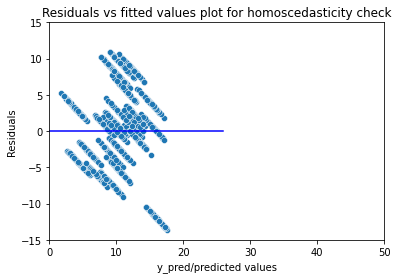

In [ ]:
p = sns.scatterplot(y_pred, residuals, )
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-15,15)
plt.xlim(0,50)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


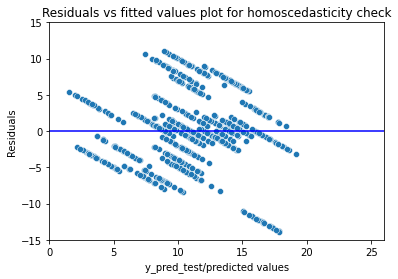

In [ ]:
p = sns.scatterplot(y_pred_1 , residuals_1)
plt.xlabel('y_pred_test/predicted values')
plt.ylabel('Residuals')
plt.ylim(-15,15)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

**Goldfeld Quandt Test**

In [ ]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_train)
lzip(name, test)

[('F statistic', 0.9665532406760614), ('p-value', 0.6807072639142049)]

In [ ]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals_1, X_test)
lzip(name, test)

[('F statistic', 1.1709453971736756), ('p-value', 0.07834694938411595)]

**4. Check for Normality of error terms/residuals**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


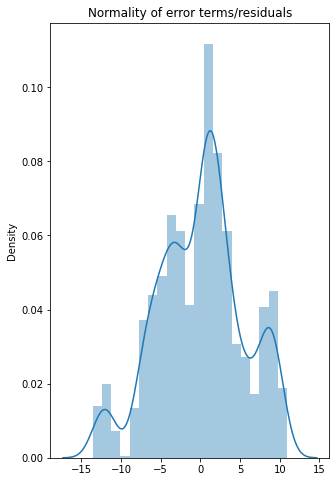

In [ ]:
plt.figure(figsize=(5,8))
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


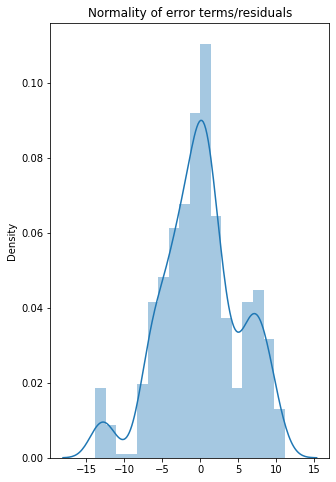

In [ ]:
plt.figure(figsize=(5,8))
p = sns.distplot(residuals_1,kde=True)
p = plt.title('Normality of error terms/residuals')

**5. No autocorrelation of residuals**

In [ ]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.29635932620172756

In [ ]:
min(diag.acorr_ljungbox(residuals_1 , lags = 40)[1])

0.0019995775240512813

<Figure size 144x360 with 0 Axes>

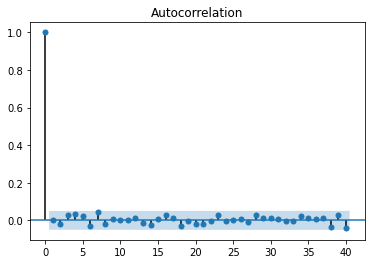

In [ ]:
import statsmodels.api as sm
# autocorrelation
plt.figure(figsize=(2,5))
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

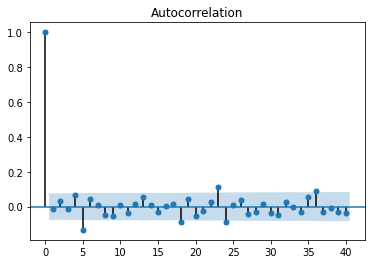

In [ ]:
sm.graphics.tsa.plot_acf(residuals_1, lags=40)
plt.show()

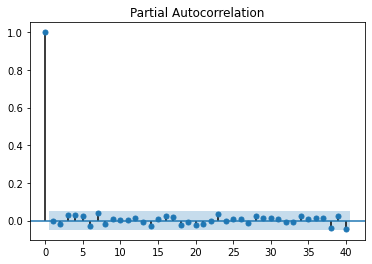

In [ ]:
# partial autocorrelation
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

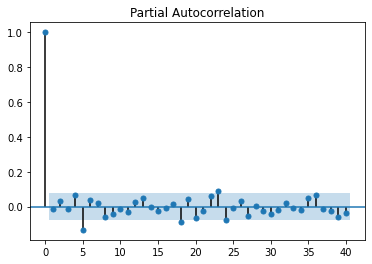

In [ ]:
# partial autocorrelation
sm.graphics.tsa.plot_pacf(residuals_1, lags=40)
plt.show()

**Shuffling data to remove order effects**

In [ ]:


# shuffling the dataset to remove order
from sklearn.utils import shuffle

df  = shuffle(df,random_state=5)
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
1319,103,17,51,25.111892,80.026213,6.209888,44.206570,watermelon
604,22,56,17,29.878881,87.327612,6.890780,44.752159,mungbean
231,42,79,85,17.223852,15.820693,6.129534,76.575810,chickpea
104,61,38,20,18.478913,62.695039,5.970458,65.438354,maize
724,20,60,25,27.325421,69.090478,6.726469,61.192509,blackgram


In [ ]:
# Selection of Feature and Target variables.

x = df[['N', 'P','K','temperature', 'humidity', 'ph', 'rainfall']]
target = df['label']

In [ ]:
# Encoding target variable 

y = pd.get_dummies(target)
y

,apple,banana,blackgram,chickpea,coconut,coffee,cotton,grapes,jute,kidneybeans,...,mango,mothbeans,mungbean,muskmelon,orange,papaya,pigeonpeas,pomegranate,rice,watermelon
1319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
604,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
231,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
724,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
376,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25, random_state= 0)

print("x_train :",x_train.shape)
print("x_test :",x_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

x_train : (1650, 7)
x_test : (550, 7)
y_train : (1650, 22)
y_test : (550, 22)


In [ ]:
# Training

forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(x_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1),
                      n_jobs=-1)

In [ ]:
# Predicting test results 

forest_pred = multi_target_forest.predict(x_test)
forest_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Calculating Accuracy

from sklearn.metrics import accuracy_score
a1 = accuracy_score(y_test, forest_pred)
print('Accuracy score:', accuracy_score(y_test, forest_pred))

Accuracy score: 0.9781818181818182


**Cross-validation**

In [ ]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(multi_target_forest,X = x_train, y = y_train,cv=5)
score


array([0.96969697, 0.96363636, 0.98181818, 0.96969697, 0.97272727])

In [ ]:
b1 = "{:.2f}".format(score.mean()*100)
b1 = float(b1)
b1

97.15

In [ ]:
c1 = (score.std()*100)
c1

0.5938156952201644

In [ ]:
print("Accuracy : {:.2f}%".format (score.mean()*100))
print("Standard Deviation : {:.2f}%".format(score.std()*100))

Accuracy : 97.15%
Standard Deviation : 0.59%


In [ ]:
# Training
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=6)
multi_target_decision = MultiOutputClassifier(clf, n_jobs=-1)
multi_target_decision.fit(x_train, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=6),
                      n_jobs=-1)

In [ ]:
# Predicting test results 

decision_pred = multi_target_decision.predict(x_test)
decision_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Calculating Accuracy

from sklearn.metrics import accuracy_score
a2 = accuracy_score(y_test,decision_pred)
print('Accuracy score:', accuracy_score(y_test,decision_pred))
a2

Accuracy score: 0.9236363636363636


0.9236363636363636

**Cross-validation**

In [ ]:
score = cross_val_score(multi_target_decision,X = x_train, y = y_train,cv=7)
score

array([0.97033898, 0.94915254, 0.91949153, 0.95762712, 0.90677966,
       0.92340426, 0.90212766])

In [ ]:
b2 = "{:.2f}".format(score.mean()*100)
b2 = float(b2)
b2

93.27

In [ ]:
c2 = (score.std()*100)
c2

2.442524166826352

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf=KNeighborsClassifier()
model = MultiOutputClassifier(knn_clf, n_jobs=-1)
model.fit(x_train, y_train)

MultiOutputClassifier(estimator=KNeighborsClassifier(), n_jobs=-1)

In [ ]:
knn_pred = model.predict(x_test)
knn_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Calculating Accuracy

a3 = accuracy_score(y_test,knn_pred)
print('Accuracy score:', accuracy_score(y_test,knn_pred))
a3

Accuracy score: 0.9727272727272728


0.9727272727272728

**Cross validation**

In [ ]:
score = cross_val_score(model,X = x_train, y = y_train,cv=7)
score

array([0.96610169, 0.98305085, 0.96610169, 0.97881356, 0.97881356,
       0.9787234 , 0.9787234 ])

In [ ]:
b3 = "{:.2f}".format(score.mean()*100)
b3 = float(b3)
b3

97.58

In [ ]:
c3 = (score.std()*100)
c3

0.6278468193244704

#**Creates pandas DataFrame.**

In [ ]:
# initialise data of lists.
data = {'Algorithms':['Random Forest', 'Decision-tree', 'KNN Classifier'],
        'Accuracy':[b1, b2, b3],
        'Standard Deviation':[c1,c2,c3]}
 

df = pd.DataFrame(data)
 
# print the data
df

,Algorithms,Accuracy,Standard Deviation
0,Random Forest,97.15,0.593816
1,Decision-tree,93.27,2.442524
2,KNN Classifier,97.58,0.627847


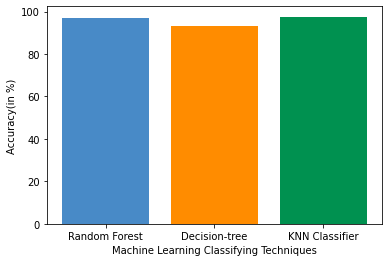

In [ ]:
# create a dataset
Algorithms = ['Random Forest', 'Decision-tree','KNN Classifier']
Accuracy = [b1, b2, b3]

x_pos = np.arange(len(Accuracy))

# Create bars with different colors
plt.bar(x_pos, Accuracy, color=['#488AC7','#ff8c00','#009150'])

# Create names on the x-axis
plt.xticks(x_pos, Algorithms)
plt.ylabel('Accuracy(in %)')
plt.xlabel('Machine Learning Classifying Techniques')

# Show graph
plt.show()

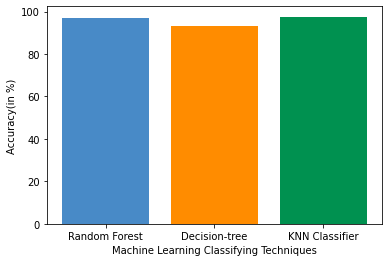

In [ ]:
# create a dataset
Algorithms = ['Random Forest', 'Decision-tree','KNN Classifier']
Accuracy = [b1, b2, b3]

x_pos = np.arange(len(Accuracy))

# Create bars with different colors
plt.bar(x_pos, Accuracy, color=['#488AC7','#ff8c00','#009150'])

# Create names on the x-axis
plt.xticks(x_pos, Algorithms)
plt.ylabel('Accuracy(in %)')
plt.xlabel('Machine Learning Classifying Techniques')

# Show graph
plt.show()

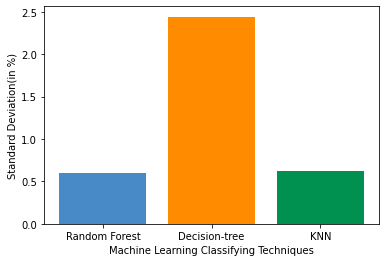

In [ ]:
# create a dataset
Algorithms = ['Random Forest', 'Decision-tree','KNN']
Accuracy = [c1, c2, c3]

x_pos = np.arange(len(Accuracy))

# Create bars with different colors
plt.bar(x_pos, Accuracy, color= ['#488AC7','#ff8c00','#009150'])

# Create names on the x-axis
plt.xticks(x_pos, Algorithms)
plt.ylabel('Standard Deviation(in %)')
plt.xlabel('Machine Learning Classifying Techniques')

# Show graph
plt.show()

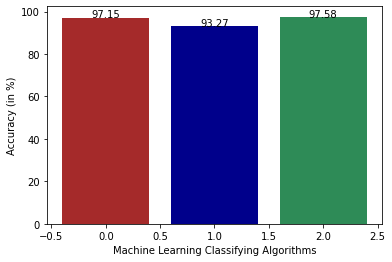

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i],ha = 'center')
  
if __name__ == '__main__':
    # creating data on which bar chart will be plot
    x = ["Random Forest", "Decision tree", "KNN"]
    y = [b1,b2,b3]


    x_pos = np.arange(len(y))

    # Create bars with different colors
    plt.bar(x_pos, y, color= ['#A52A2A','#00008B','#2E8B57'])
      
    # calling the function to add value labels
    addlabels(x, y)
      
    # giving X and Y labels
    plt.xlabel("Machine Learning Classifying Algorithms")
    plt.ylabel("Accuracy (in %)")
      
    # visualizing the plot
    plt.show()

In [ ]:
"""#bff1f1
#fadadd
#ddfada
sourajita dewasi9:47 PM
#e7dafa
#bb97f1"""

'#bff1f1\n#fadadd\n#ddfada\nsourajita dewasi9:47 PM\n#e7dafa\n#bb97f1'

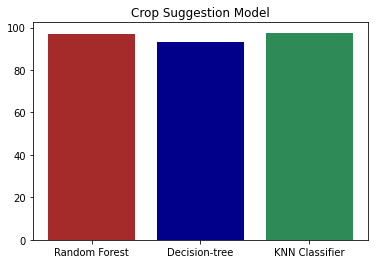

In [ ]:
plt.bar(df['Algorithms'], df['Accuracy'], color = ['#A52A2A','#00008B','#2E8B57'])

plt.title('Crop Suggestion Model')
 
# Show Plot
plt.show()

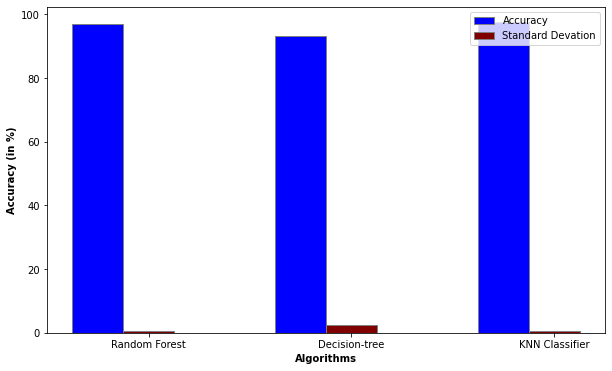

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(10, 6))
 
# set height of bar
Algorithms = ['Random Forest', 'Decision-tree', 'KNN Classifier']
Accuracy = [b1, b2, b3]
Standard_Deviation = [c1,c2,c3]
 
# Set position of bar on X axis
br1 = np.arange(len(Accuracy))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Accuracy, color ='blue', width = barWidth,
        edgecolor ='grey', label ='Accuracy')
plt.bar(br2, Standard_Deviation, color ='maroon', width = barWidth,
        edgecolor ='grey', label ='Standard Devation')
 
# Adding Xticks
plt.xlabel('Algorithms', fontweight ='bold', fontsize = 10)
plt.ylabel('Accuracy (in %)', fontweight ='bold', fontsize = 10)
plt.xticks([r + barWidth for r in range(len(Accuracy))],
        Algorithms)
 
plt.legend()
plt.show()

#**Saving the trained Random Forest model**

In [ ]:
import pickle
# Dump the trained Naive Bayes classifier with Pickle
RF_pkl_filename = 'RandomForest.pkl'
# Open the file to save as pkl file
RF_Model_pkl = open(RF_pkl_filename, 'wb')
pickle.dump(multi_target_forest, RF_Model_pkl)
# Close the pickle instances
RF_Model_pkl.close()